
# Stroke Prediction with SMOTE, Visual EDA, and Model Interpretability (LIME & SHAP)

This notebook enhances a standard stroke prediction pipeline by:
- Applying **SMOTE** to balance imbalanced classes
- Adding **exploratory visualizations**
- Implementing **model interpretability tools** such as **LIME** and **SHAP**


In [6]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from imblearn.over_sampling import SMOTE

import shap
import lime
import lime.lime_tabular


In [7]:

# Load and preprocess
df = pd.read_csv("stroke.csv")
df['bmi'] = df['bmi'].fillna(df['bmi'].median())
df = df.drop(columns=['id'])
df['age_bmi_score'] = df['age'] * df['bmi']
df = pd.get_dummies(df, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], drop_first=True)


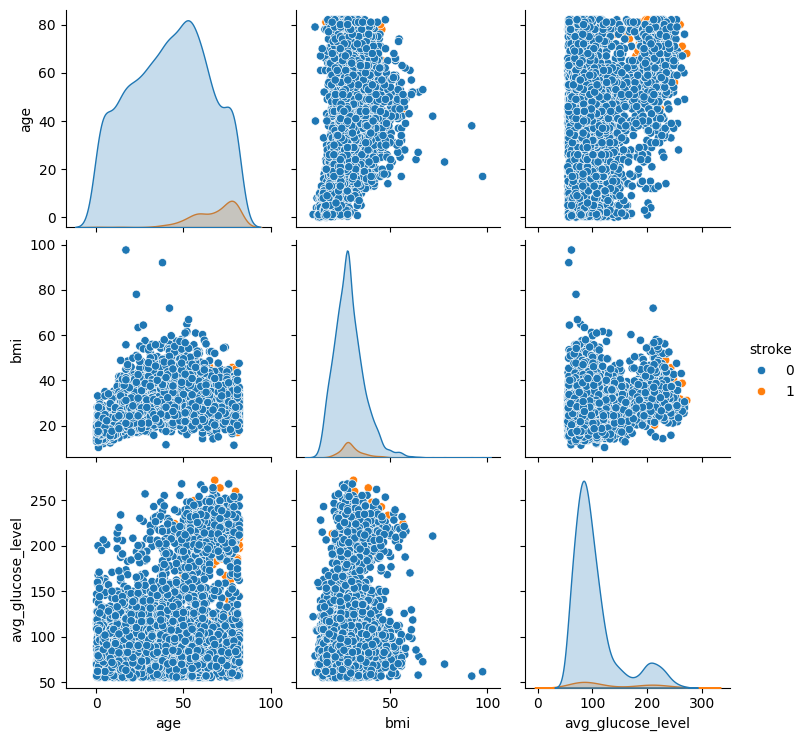

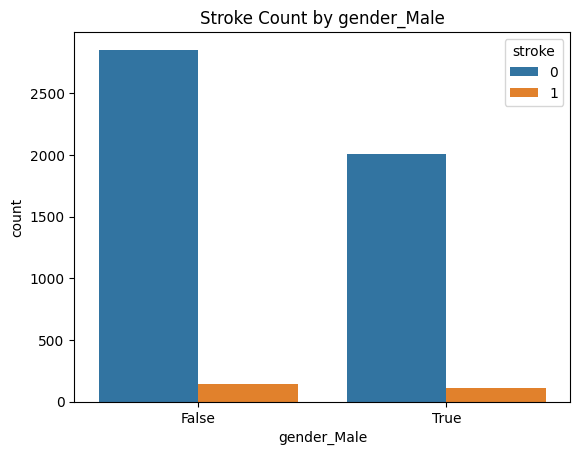

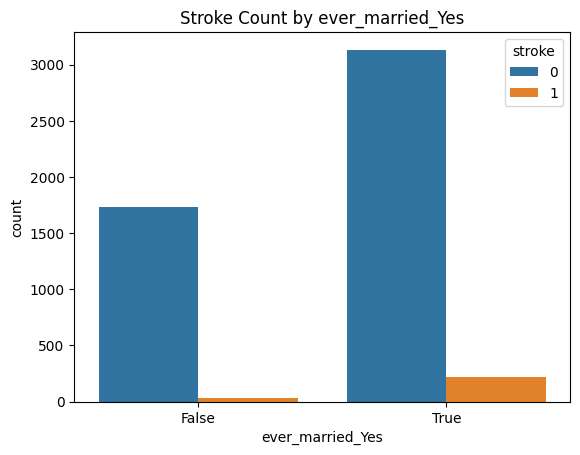

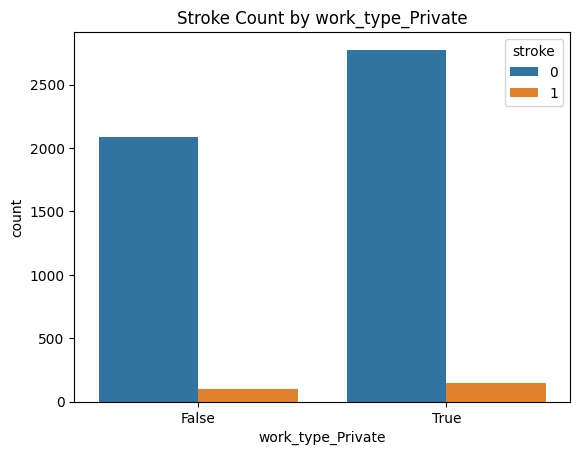

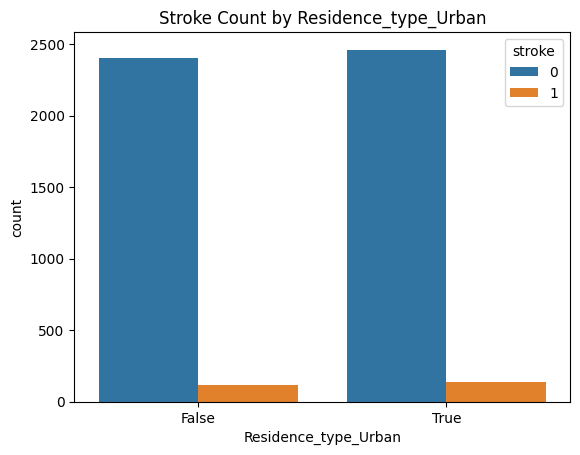

In [8]:

# Visual EDA
sns.pairplot(df[['age', 'bmi', 'avg_glucose_level', 'stroke']], hue='stroke')
plt.show()

# Countplots
cat_cols = ['gender_Male', 'ever_married_Yes', 'work_type_Private', 'Residence_type_Urban']
for col in cat_cols:
    sns.countplot(x=col, hue='stroke', data=df)
    plt.title(f'Stroke Count by {col}')
    plt.show()


In [9]:

X = df.drop('stroke', axis=1)
y = df['stroke']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)


In [10]:

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split on balanced data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


In [11]:

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.91      0.93       973
           1       0.92      0.95      0.93       972

    accuracy                           0.93      1945
   macro avg       0.93      0.93      0.93      1945
weighted avg       0.93      0.93      0.93      1945



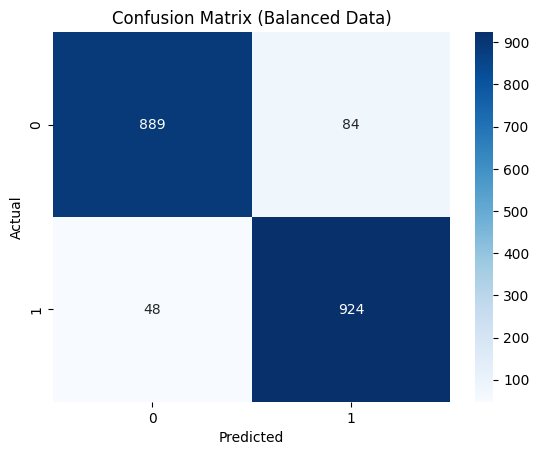

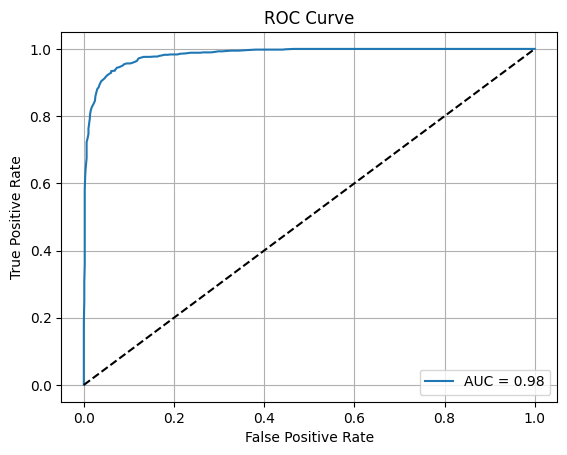

In [12]:

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Balanced Data)')
plt.show()

# ROC curve
y_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


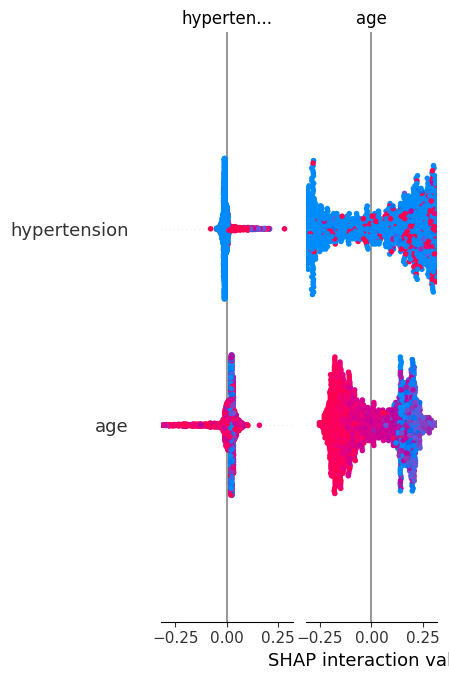

In [15]:
# SHAP global explanation
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
# Use class_inds to specify the class for the summary plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, class_inds=1)

In [16]:

# LIME explanation for a single instance
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X.columns, class_names=['No Stroke', 'Stroke'], discretize_continuous=True)
i = 5
exp = explainer.explain_instance(X_test.values[i], model.predict_proba, num_features=10)
exp.show_in_notebook(show_table=True)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [17]:

joblib.dump(model, 'rf_stroke_balanced.pkl')
joblib.dump(scaler, 'scaler_balanced.pkl')


['scaler_balanced.pkl']

In [3]:
%pip install lime shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4ba52d3be03dedca3c0e66b24664c8a3ef690fe7ce4987d8de57ea82b885fa16
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
